#### Notes
So for some context, in [this notebook](https://github.com/namoopsoo/aviation-pilot-physiology-hmm/blob/master/notes/2019-12-21.md) I baked a dataset using this approach:

```python
out = mu.make_data(df1to2, crews={'training': [1],
                    'test': [2]},
              window_size=64,
               row_batch_size=10000,
         feature_cols=cols,
              save_dir=newdir)
```
- I had used that to build the `train.h5` and `test.h5` . But I looked at the outdir `data/2019-12-21T215926Z` and didn't find the balanced data.
- And this `mu.make_data` func creates smaller datasets of `10k` each , per the `row_batch_size=10000` param.
- That same notebook ^, I also discovered the [partial fit of MinMaxScaler](https://github.com/namoopsoo/aviation-pilot-physiology-hmm/blob/master/notes/2019-12-21.md#oh-wow-partial-fit) , 
- So I ended up writing `build_scaler_from_h5` in there , 
- But also nicely I saw the MinMaxScaler lets you use one scaler for multiple columns like [here](https://github.com/namoopsoo/aviation-pilot-physiology-hmm/blob/master/notes/2019-12-21.md#multi-scaler-instead) , `build_many_scalers_from_h5` . 

```python
# trainloc = 'data/2019-12-21T215926Z/train.h5'
output = build_many_scalers_from_h5(
                        trainloc, 
                        datasets=[x for x in h5_keys(trainloc) 
                               if '_X' in x]
)
```
- Ok but in that notebook ^ I did not seem to wrap up showing producing the data
- I looked at my [2019-12-22 notebook](https://github.com/namoopsoo/aviation-pilot-physiology-hmm/blob/master/notes/2019-12-22.md) , and I'm using 

```
outdir = 'history/2019-12-22T174803Z'
train_loc = f'{outdir}/train_balanced.h5'
test_loc = f'{outdir}/test_balanced.h5'
```
in there but I did not show how I produced this. I wonder if I did this on a shell and forgot to record it.
- Ah ok I had an [updated 2019-12-21 notebook](https://github.com/namoopsoo/aviation-pilot-physiology-hmm/blob/master/notes/2019-12-21--update.md) 

#### and..
```python
trainloc = 'data/2019-12-21T215926Z/train.h5'
apply_scalers(trainloc, 
                   datasets=[x for x in h5_keys(trainloc) 
                               if '_X' in x],
                   scaler=output[0],
                   outloc=f'{outdir}/train_scaled.h5'

                  )
mu.transfer(source_location=trainloc, 
            source_datasets=[x for x in h5_keys(trainloc) 
                               if '_Y' in x], 
            save_location=f'{outdir}/train_scaled.h5')
```

```python
%%time
# ok... make train set...
# max 7625
train_scaled_loc = f'{outdir}/train_scaled.h5'
train_balanced_loc = f'{outdir}/train_balanced.h5'

datasets = list(zip([x for x in mu.h5_keys(train_scaled_loc) 
                               if '_X' in x],
                    [x for x in mu.h5_keys(train_scaled_loc) 
                               if '_Y' in x]))

for k in [0, 1, 2, 3]:
    mu.transfer_data(
        source_location=train_scaled_loc,
        source_datasets=datasets,
        save_location=train_balanced_loc,
        label=k,
        howmany=7625)
    
```

#### next
- ok so to summarize, if I want to create another test set ...
- This one I want to create from the same _Crew=1_ as the train set was created, to test the theory that there is bad scaling possibly in the main test set I have. 

```python

# Let me put the new file into the same dir.
datadir = 'history/2019-12-22T174803Z'

# Load scalers
stored_scaler = joblib.load('history/2019-12-22T174803Z/scalers.joblib')
#print(vars(stored_scaler['scalers'])['n_samples_seen_'])



```


In [1]:

from importlib import reload
import os
import pandas as pd
from io import StringIO
import itertools
import ipdb
import datetime
from collections import Counter

import h5py
import json
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import joblib
print(tf.__version__)

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM

from keras.callbacks import EarlyStopping
from tensorflow.compat.v1.losses import sparse_softmax_cross_entropy

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import mytf.s3utils as msu
import mytf.utils as mu
import mytf.validation as mv
import mytf.plot as mp

1.14.0


Using TensorFlow backend.


In [2]:
tf.enable_eager_execution()


### 2020-01-20

In [18]:
# Original train scaled..
# Let me put the new file into the same dir.
datadir = 'history/2019-12-22T174803Z'

train_scaled_loc = f'{datadir}/train_scaled.h5'
train_balanced_loc = f'{datadir}/train_balanced.h5'

# Looking at it, I had truly quite a lot of mini `10k` large datasets in there,
# So there should be plenty to spare to make more data sets.
print(mu.h5_keys(train_scaled_loc))

['dataset_0_X_scaled', 'dataset_0_Y', 'dataset_10_X_scaled', 'dataset_10_Y', 'dataset_11_X_scaled', 'dataset_11_Y', 'dataset_12_X_scaled', 'dataset_12_Y', 'dataset_13_X_scaled', 'dataset_13_Y', 'dataset_14_X_scaled', 'dataset_14_Y', 'dataset_15_X_scaled', 'dataset_15_Y', 'dataset_16_X_scaled', 'dataset_16_Y', 'dataset_17_X_scaled', 'dataset_17_Y', 'dataset_18_X_scaled', 'dataset_18_Y', 'dataset_19_X_scaled', 'dataset_19_Y', 'dataset_1_X_scaled', 'dataset_1_Y', 'dataset_20_X_scaled', 'dataset_20_Y', 'dataset_21_X_scaled', 'dataset_21_Y', 'dataset_22_X_scaled', 'dataset_22_Y', 'dataset_23_X_scaled', 'dataset_23_Y', 'dataset_24_X_scaled', 'dataset_24_Y', 'dataset_25_X_scaled', 'dataset_25_Y', 'dataset_26_X_scaled', 'dataset_26_Y', 'dataset_27_X_scaled', 'dataset_27_Y', 'dataset_28_X_scaled', 'dataset_28_Y', 'dataset_29_X_scaled', 'dataset_29_Y', 'dataset_2_X_scaled', 'dataset_2_Y', 'dataset_30_X_scaled', 'dataset_30_Y', 'dataset_31_X_scaled', 'dataset_31_Y', 'dataset_32_X_scaled', 'datase

In [19]:
mu.count_data_in_location(loc=train_scaled_loc,
                          datasets=[x for x in mu.h5_keys(train_scaled_loc) 
                               if '_Y' in x])


0it [00:00, ?it/s]
45it [00:00, 316.22it/s]


{0: 234038, 1: 7625, 2: 179699, 3: 23090}

In [20]:
loc = train_scaled_loc
datasets = [x for x in mu.h5_keys(train_scaled_loc) 
                               if '_Y' in x]
    
counters_index = {}
for i, name in tqdm(enumerate(datasets)):
    with h5py.File(loc, 'r+') as fd:
        Y = fd[name].__array__()
        labels = np.argmax(Y, axis=1)
        counters_index[i] = dict(Counter(labels))

total_counts = {k: [x.get(k) for x in counters_index.values() 
                    if x.get(k) is not None]
               for k in [0, 1, 2, 3]}
total_label_sums = {k: sum(total_counts[k]) for k in [0, 1, 2, 3]}
print(total_counts)
print(total_label_sums)



{0: [1650, 8580, 8096, 8136, 8655, 8655, 8655, 8655, 8655, 9328, 9936, 6099, 9936, 5377, 3997, 8655, 8248, 8655, 8655, 9936, 7058, 8655, 8481, 9872, 9936, 9071, 7013, 7588, 7805], 1: [3837, 865, 2923], 2: [8286, 9936, 4495, 9936, 9936, 9936, 9936, 9936, 9936, 9936, 9936, 9936, 5875, 9936, 9936, 9936, 9936, 9936, 9936, 2067], 3: [1356, 1840, 1800, 1281, 1281, 1281, 1281, 1281, 544, 1281, 1688, 1281, 1281, 2878, 1281, 1455]}
{0: 234038, 1: 7625, 2: 179699, 3: 23090}


In [21]:
from tqdm.auto import tqdm

In [22]:
# Ah crap oops, so there was actually a very small amount of `label=1` in the entirety of this
# `train.h5` , so there is no more to take from . 
#
# Ok but instead, I can actually try running the typical validation I run,
# on that original train data since I had never done that before.
#
# Using yesterdays model dir...
workdir = 'history/2020-01-19T180030Z'

train_shuff_loc = f'{datadir}/train_scaled_balanced_shuffled.h5'


In [23]:
## Double check access to model files...

epoch = 0
print(len(list(np.arange(0, 1100, 200))))
for batch in tqdm(list(np.arange(0, 1100, 200))):
    step = batch
    prefix = (f'{workdir}/epoch_{str(epoch).zfill(3)}'
                           f'_batch_{str(batch).zfill(5)}')

    modelname = f'{prefix}_model.h5'
    print(modelname, os.path.exists(modelname))

6


history/2020-01-19T180030Z/epoch_000_batch_00000_model.h5 True
history/2020-01-19T180030Z/epoch_000_batch_00200_model.h5 True
history/2020-01-19T180030Z/epoch_000_batch_00400_model.h5 True
history/2020-01-19T180030Z/epoch_000_batch_00600_model.h5 True
history/2020-01-19T180030Z/epoch_000_batch_00800_model.h5 True
history/2020-01-19T180030Z/epoch_000_batch_01000_model.h5 True



In [24]:
# So below, using `train_shuff_loc` instead of `test_loc` , since
# again, I'm measuring performance on full train set ...
print('starting validation of original full training set... ', mu.quickts())

batch_losses_vec = []

epoch = 0
for batch in tqdm(list(np.arange(200, 1100, 200))):
    step = batch
    prefix = (f'{workdir}/epoch_{str(epoch).zfill(3)}'
                           f'_batch_{str(batch).zfill(5)}')

    modelname = f'{prefix}_model.h5'
    print(modelname, os.path.exists(modelname))

    steploss = mv.perf_wrapper(modelname,
                               dataloc=train_shuff_loc,
                               eager=True,
                              batch_size=32)
    batch_losses_vec.append([float(x) for x in steploss])
    mu.to_json_local({'batch_losses_vec': batch_losses_vec,
                  'step': int(step)
              }, 
              f'{prefix}_validation_losses.json')
    
print('done validation', mu.quickts())
#####
lossesarr = np.array(batch_losses_vec)
meanlossesarr = np.mean(lossesarr, axis=1)

batch_losses_vec[:5]
#batch_losses_vec = []
#for step in np.arange(0, 1068, 10):
# [2.8359528, 0.45356295, 1.7049086, 4.099845]

plt.plot([x[0] for x in batch_losses_vec], color='blue', label='0')
plt.plot([x[1] for x in batch_losses_vec], color='green', label='1')
plt.plot([x[2] for x in batch_losses_vec], color='red', label='2')
plt.plot([x[3] for x in batch_losses_vec], color='orange', label='3')
plt.plot(meanlossesarr, color='black', label='mean')
plt.title(f'validation losses  (model {ts})')
plt.legend()     
        

starting validation of original full training set...  2020-01-20T163214Z


history/2020-01-19T180030Z/epoch_000_batch_00200_model.h5 True


KeyError: "Unable to open object (object 'X_0' doesn't exist)"

In [25]:
print(mu.h5_keys(train_shuff_loc))
print(mu.h5_keys(train_scaled_loc))
print(mu.h5_keys(train_balanced_loc))


['X', 'Ylabels']
['dataset_0_X_scaled', 'dataset_0_Y', 'dataset_10_X_scaled', 'dataset_10_Y', 'dataset_11_X_scaled', 'dataset_11_Y', 'dataset_12_X_scaled', 'dataset_12_Y', 'dataset_13_X_scaled', 'dataset_13_Y', 'dataset_14_X_scaled', 'dataset_14_Y', 'dataset_15_X_scaled', 'dataset_15_Y', 'dataset_16_X_scaled', 'dataset_16_Y', 'dataset_17_X_scaled', 'dataset_17_Y', 'dataset_18_X_scaled', 'dataset_18_Y', 'dataset_19_X_scaled', 'dataset_19_Y', 'dataset_1_X_scaled', 'dataset_1_Y', 'dataset_20_X_scaled', 'dataset_20_Y', 'dataset_21_X_scaled', 'dataset_21_Y', 'dataset_22_X_scaled', 'dataset_22_Y', 'dataset_23_X_scaled', 'dataset_23_Y', 'dataset_24_X_scaled', 'dataset_24_Y', 'dataset_25_X_scaled', 'dataset_25_Y', 'dataset_26_X_scaled', 'dataset_26_Y', 'dataset_27_X_scaled', 'dataset_27_Y', 'dataset_28_X_scaled', 'dataset_28_Y', 'dataset_29_X_scaled', 'dataset_29_Y', 'dataset_2_X_scaled', 'dataset_2_Y', 'dataset_30_X_scaled', 'dataset_30_Y', 'dataset_31_X_scaled', 'dataset_31_Y', 'dataset_32_X

starting validation of original full training set...  2020-01-20T163436Z


history/2020-01-19T180030Z/epoch_000_batch_00200_model.h5 True
history/2020-01-19T180030Z/epoch_000_batch_00400_model.h5 True
history/2020-01-19T180030Z/epoch_000_batch_00600_model.h5 True
history/2020-01-19T180030Z/epoch_000_batch_00800_model.h5 True
history/2020-01-19T180030Z/epoch_000_batch_01000_model.h5 True

done validation 2020-01-20T164947Z


NameError: name 'ts' is not defined

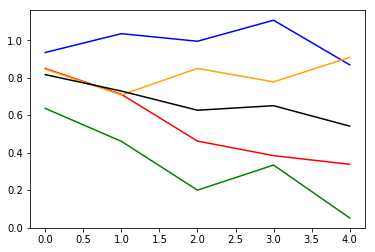

In [26]:
# ok try one more time... with `train_balanced_loc` instead of the `train_shuff_loc`, 
# since `train_shuff_loc` doesnt have per label data so cant be used for the evaluation
print('starting validation of original full training set... ', mu.quickts())

batch_losses_vec = []

epoch = 0
for batch in tqdm(list(np.arange(200, 1100, 200))):
    step = batch
    prefix = (f'{workdir}/epoch_{str(epoch).zfill(3)}'
                           f'_batch_{str(batch).zfill(5)}')

    modelname = f'{prefix}_model.h5'
    print(modelname, os.path.exists(modelname))

    steploss = mv.perf_wrapper(modelname,
                               dataloc=train_balanced_loc,
                               eager=True,
                              batch_size=32)
    batch_losses_vec.append([float(x) for x in steploss])
    mu.to_json_local({'batch_losses_vec': batch_losses_vec,
                  'step': int(step)
              }, 
              f'{prefix}_validation_losses.json')
    
print('done validation', mu.quickts())
#####
lossesarr = np.array(batch_losses_vec)
meanlossesarr = np.mean(lossesarr, axis=1)

batch_losses_vec[:5]
#batch_losses_vec = []
#for step in np.arange(0, 1068, 10):
# [2.8359528, 0.45356295, 1.7049086, 4.099845]

plt.plot([x[0] for x in batch_losses_vec], color='blue', label='0')
plt.plot([x[1] for x in batch_losses_vec], color='green', label='1')
plt.plot([x[2] for x in batch_losses_vec], color='red', label='2')
plt.plot([x[3] for x in batch_losses_vec], color='orange', label='3')
plt.plot(meanlossesarr, color='black', label='mean')
plt.title(f'validation losses  (model {ts})')
plt.legend()     
        